In [192]:
def importdata():
    df = pd.read_csv('../data/df_points_2019-2020.csv')
    df = df[['bike_id','lat','lng','timestood','time_start','time_end','flag','hex_id']]
    
    df['time_start'] = pd.to_datetime(df['time_start'])
    
    return df

In [193]:
def create_onedf_hexid(df,hex_id):
    onedfhexid = pd.DataFrame(columns= ['bike_id','lat','lng','timestood','time_start','time_end','flag','hex_id'])
    for ind in df.index:
        if df['hex_id'][ind] == hex_id:
            onedfhexid.loc[df.index[ind]] = df.iloc[ind]
            #onedfhexid.append(df[ind], ignore_index = True)
    return onedfhexid.reset_index(drop=True)

In [194]:
def create_tsdata(_year,_days):
    rng = pd.date_range(f'{_year}-01-01', periods=_days, freq='D')
    tsdata = pd.DataFrame({ 'date': rng, 'idle_time' : np.nan, 'list': np.nan, 'bike_count': np.nan}) 
    return tsdata.set_index('date')

In [195]:
def add_rows_to_days(tsdata,onedfhexid):
    # iteriere über alle Tage
    for date in tqdm(tsdata.index):
        list = []
        # Adde alle Rows in die List wenn Tag = Tag
        for ind in onedfhexid.index:
            if date.date() == onedfhexid['time_start'][ind].date():
                list.append(onedfhexid['timestood'][ind])
        #print(len(list))        
        # Setze Mittelwert für Tage
        if len(list) == 0:
            tsdata['bike_count'][date] = 1
            continue
        else:
            tsdata['bike_count'][date] = len(list)
            tsdata['idle_time'][date] = statistics.mean(list)
    return tsdata

In [196]:
def get_rows_one_day(day,onedfhexid):
    list=[]
    for ind in onedfhexid.index:
        if day == onedfhexid['time_start'][ind].date():
            list.append(onedfhexid['timestood'][ind])
    print(list)
    print(statistics.mean(list))

In [197]:
def roling_weighted_mean(tsdata,_year,_days):
    x = []
    rng2 = pd.date_range(f'{_year}-01-01', periods=_days, freq='D')
    data_mean2 = pd.DataFrame({ 'date': rng2, 'idle_time' : np.nan})
    data_mean2 = data_mean2.set_index('date')
    
    for window in tsdata.rolling(window = 7 , center = True):
        #print(window)
        x.append(np.average(window['idle_time'], weights = window['bike_count']))
    
    data_mean2['idle_time'] = x
    return data_mean2

In [198]:
def plot(x):
    fig, ax1 = plt.subplots(figsize = (20,10))
    
    ax1.plot(x['idle_time'], linewidth=2,color='red', label='Idle Time Mean')
    ax1.set_xlabel('day')
    ax1.set_ylabel('timestood (min)')
    ax1.tick_params(axis ='y', labelcolor = 'red') 
    
    ax2 = ax1.twinx()
    ax2.plot(x['bike_count'], linewidth=2, label='bike_count')
    ax2.set_ylabel('bike_count')
    ax2.tick_params(axis ='y', labelcolor = 'blue')
    
    plt.show()

In [199]:
def plot_details(tsdata,data_7d_rol,data_2m_rol,data_7d_mean2,hex_id,total_bike_count):
    fig, ax = plt.subplots(figsize = (20,10))
    
    # plotting daily data
    ax.plot(tsdata['idle_time'], marker='.', markersize=2, color='0.6',linestyle='None', label='Daily')
    # plotting 7-day rolling data
    ax.plot(data_7d_rol['idle_time'],color = 'blue', linewidth=2, label='7-d Rolling Mean')
    ax.plot(data_7d_mean2['idle_time'],color = 'green', linewidth=2, label='7-d Rolling Mean')
    # plotting 2-Month rolling data -trend-
    ax.plot(data_2m_rol['idle_time'], color='0.2', linewidth=3, label='Trend (2M)')
    ax.legend()
    ax.set_xlabel('day')
    ax.set_ylabel('timestood (min)')
    ax.set_title(f'Trends in idel time of bikes in hex: {hex_id} with a total of {total_bike_count} rentals')
    
    ax2 = ax.twinx()
    ax2.plot(data_7d_rol['bike_count'],linewidth=1, color='0.5',label='Bike Count 7-d RM')
    ax2.set_xlabel('day')
    ax2.set_ylabel('bikes in hex per day')
    ax2.legend()
    
    plt.show()

In [200]:
def fix_missing_values(tsdata):
    data_freq = tsdata.asfreq('D')
    data_freq = data_freq.ffill()
    return data_freq

# Main

In [201]:
import pandas as pd
pd.options.mode.chained_assignment = None
from tqdm import tqdm
from datetime import timedelta, datetime, date
pd.set_option('display.max_rows', None)
import weightedstats

import numpy as np
import statistics
import matplotlib.pyplot as plt

### Define the HEX_id

#hex_id = '8a1f1a8d9d97fff'
hex_id = '8a1f1a8cb4cffff'
#hex_id = '8a1f1a8cb4dffff'
#hex_id = '8a1f1a8cb71ffff'

days=730
year=2019
data_columns = ['idle_time','bike_count']

df = importdata()
onedfhexid = create_onedf_hexid(df,hex_id)
tsdata = create_tsdata(year,days)
tsdata = add_rows_to_days(tsdata,onedfhexid)
#fix missing values with ffill

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 730/730 [01:05<00:00, 11.17it/s]


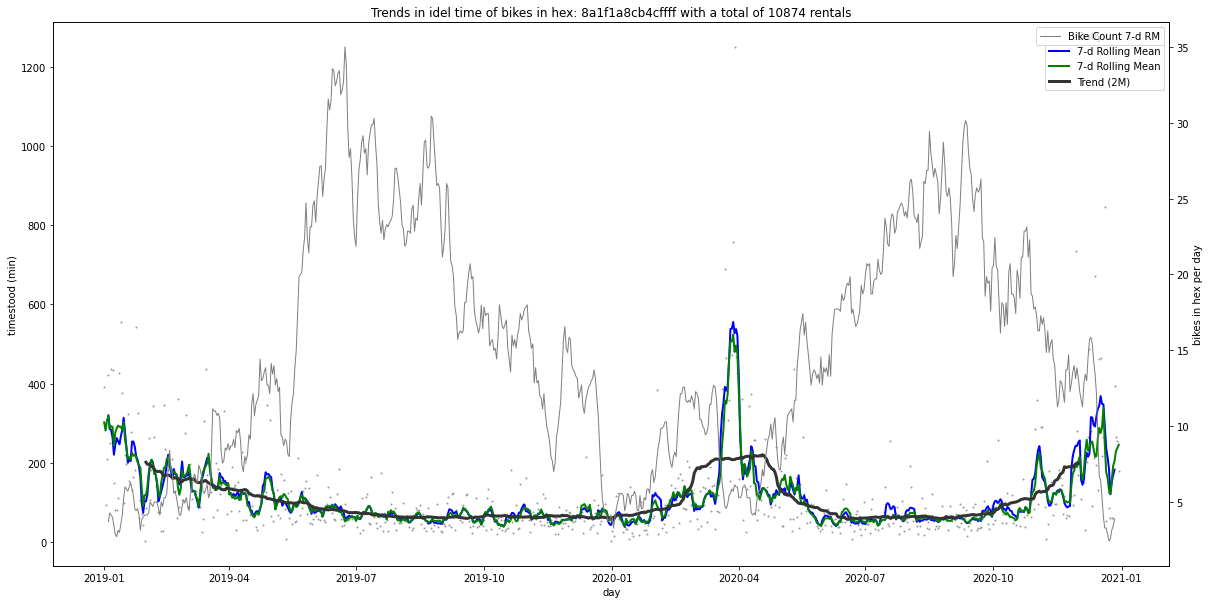

In [202]:
tsdata = fix_missing_values(tsdata)
total_bike_count = int(tsdata['bike_count'].sum())

data_7d_rol = tsdata[data_columns].rolling(window = 7, center = True).mean()
data_2m_rol = tsdata[data_columns].rolling(window = 60, center = True).mean()
data_7d_mean2 = roling_weighted_mean(tsdata,year,days)


plot_details(tsdata,data_7d_rol,data_2m_rol,data_7d_mean2,hex_id,total_bike_count)